## Imports and Helpers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
%matplotlib inline

In [2]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [3]:
def table_tag(fragments, columns):
    column = 1
    s = '<table><tr>'
    for fragment in fragments:
        s = s + '<td>' + fragment + '</td>'
        column = column + 1
        if column > columns:
            s = s + '</tr><tr>'
            column = 1
    s = s + '</td></tr></table>'
    return s

In [4]:
def big_figure():
    fig = plt.figure()
    fig.set_size_inches(w=15,h=10)
    return fig

## Settings

In [5]:
run_folder = 'tracks/desk/routes/X/runs/2'

## Analysis

In [6]:
route_folder = os.path.dirname(os.path.dirname(run_folder)) # two folders up
route_folder

'tracks/desk/routes/X'

In [8]:
# Create / Show videos

import subprocess
video_tags = []
for f in ['video_left','video_right']:
    mp4_path = os.path.join(run_folder,f+'.mp4')
    if not os.path.exists(mp4_path):
        avi_path = os.path.join(run_folder,f+'.avi')
        if os.path.exists(avi_path):
            s = 'ffmpeg -i "{0}" -vcodec h264 -acodec copy "{1}"'.format(avi_path,mp4_path)
            subprocess.check_call(s,shell=True)
    if os.path.exists(mp4_path):
        video_tags.append(video_tag(mp4_path,title=f))
    else:
        print("couldn't find ", mp4_path)
display.display(display.HTML(table_tag(video_tags, columns=2)))


video_left,video_right


In [9]:
def get_td(folder):
    td = pd.read_csv(os.path.join(folder,'td.csv'),parse_dates=(['timestamp']))
    td.t = (td.ms - td.ms.values[0])/1000.
    #generate some extra columns
    for p in ['fl','fr','bl','br']:
        td[p] = td['odo_'+p] - td['odo_'+p][0]

    # create td.heading from yaw, represents total turn angle from start
    dy = td.yaw.diff()
    td.heading = np.cumsum(dy + 360*(dy<-190))
    
    # create center wheels
    td.fc = (td.fl+td.fr)/2. # front center
    td.bc = (td.bl+td.br)/2. # back center
    return td


In [10]:
route = get_td(route_folder)
run = get_td(run_folder)
print(run.columns)

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl',
       'odo_fl_us', 'odo_fr', 'odo_fr_us', 'odo_bl', 'odo_bl_us', 'odo_br',
       'odo_br_us', 'odo_spur', 'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax',
       'ay', 'az', 'imu_calib', 'fl', 'fr', 'bl', 'br'],
      dtype='object')


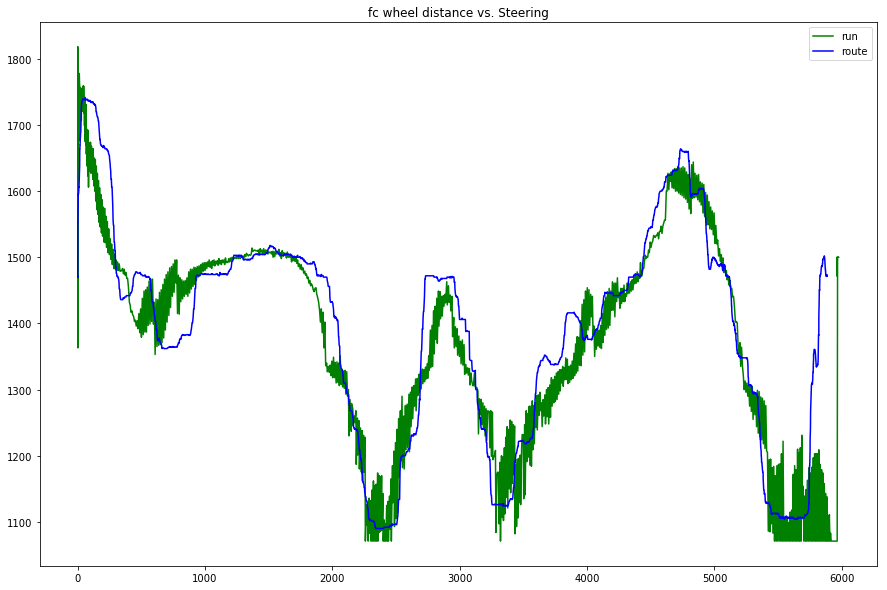

In [31]:
big_figure()
plt.title('fc wheel distance vs. Steering')
plt.plot(run.fc,run.str,color='g',label='run')
plt.plot(route.fc,route.str,color='b',label='route')
plt.legend();


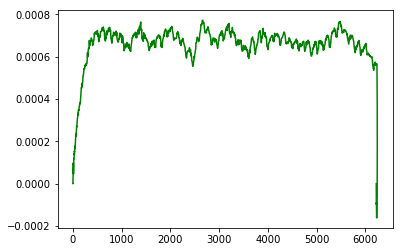

In [108]:
i = 5
plt.plot(run.fr[i:],(run.fr.values[i:]-run.fr.values[:-i])/(run.odo_fr_us.values[i:]-run.odo_fr_us.values[:-i]+1),color='g')
#plt.plot(route.fr[i:],route.fr.values[i:]-route.fr.values[:-i],color='b')

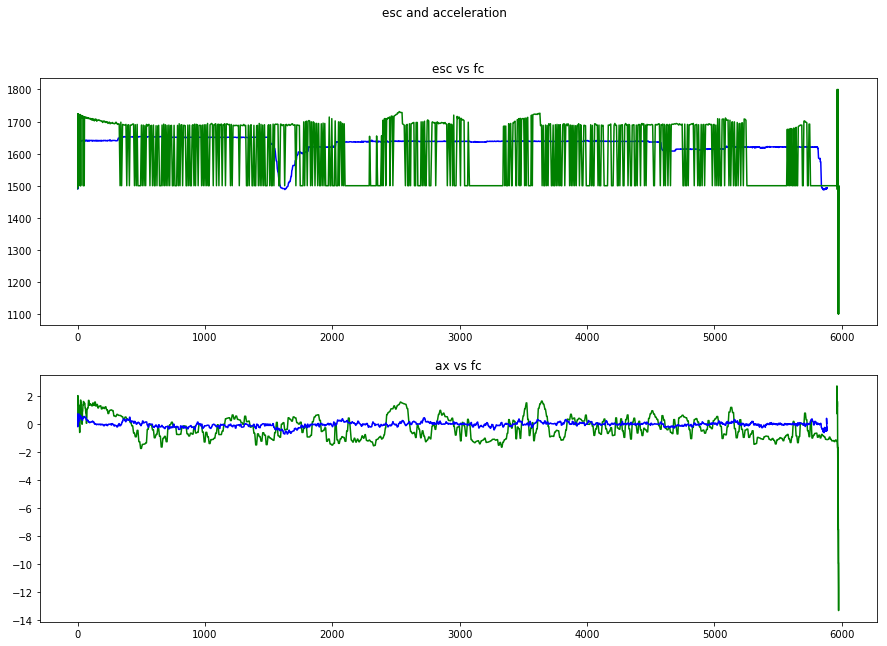

In [38]:
# research velocity
fig = big_figure()
fig.suptitle("esc and acceleration")
plt.subplot(2,1,1)
plt.plot(route.fc, route.esc, color='b')
plt.plot(run.fc, run.esc, color='g')
plt.title("esc vs fc")
plt.subplot(2,1,2)
plt.title('ax vs fc')
plt.plot(run.fc, run.ax,color='g');
plt.plot(route.fc, route.ax,color='b');


In [70]:
fl = run[['fr','odo_fr_us']]
fl.drop_duplicates(inplace=False)
d=fl.diff()



               fr     odo_fr_us
100  3.923189e+60  7.474459e+63
101  3.923189e+60  8.050383e+63
102  3.923189e+60  6.849887e+63
103  4.707826e+60  9.126906e+63
104  3.923189e+60  7.799299e+63
               fr     odo_fr_us
100  7.237006e+79  1.378794e+83
101  7.237006e+79  1.485034e+83
102  7.237006e+79  1.263581e+83
103  8.684407e+79  1.683617e+83
104  7.237006e+79  1.438717e+83


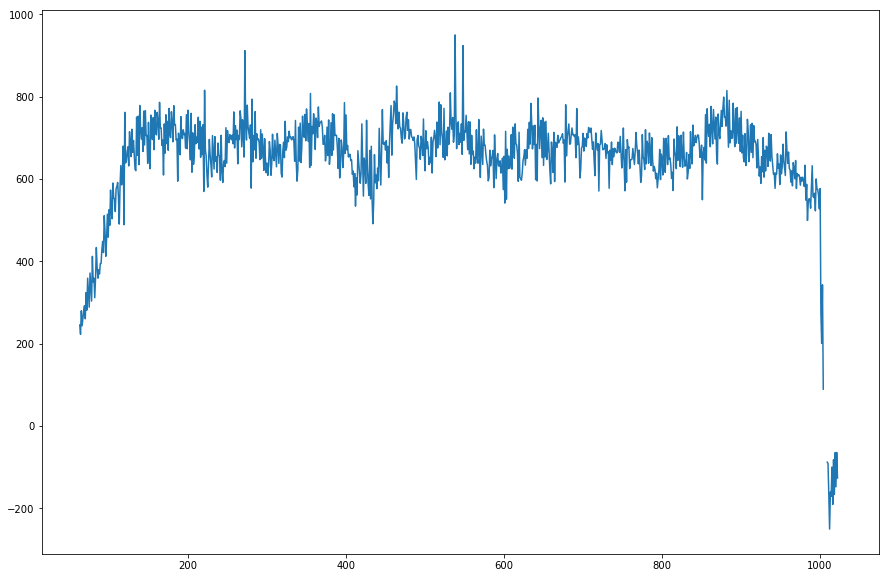

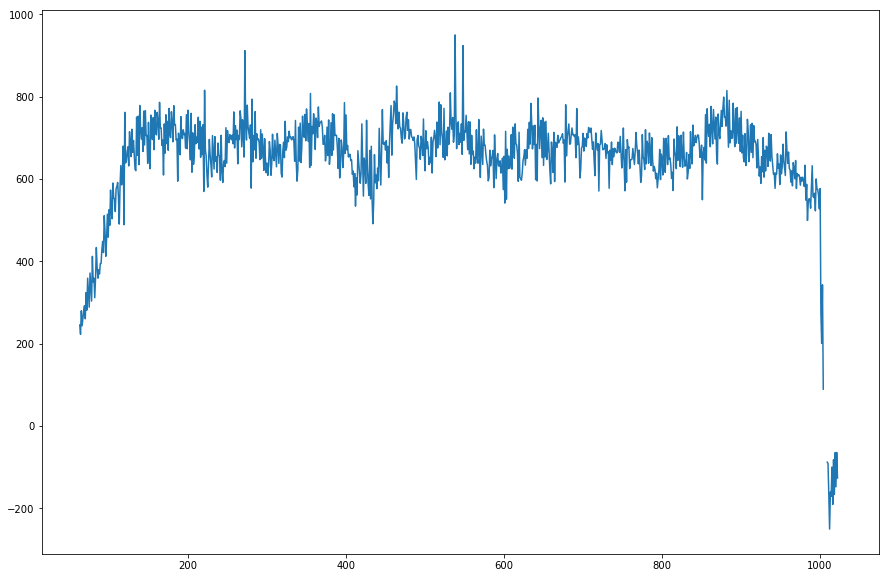

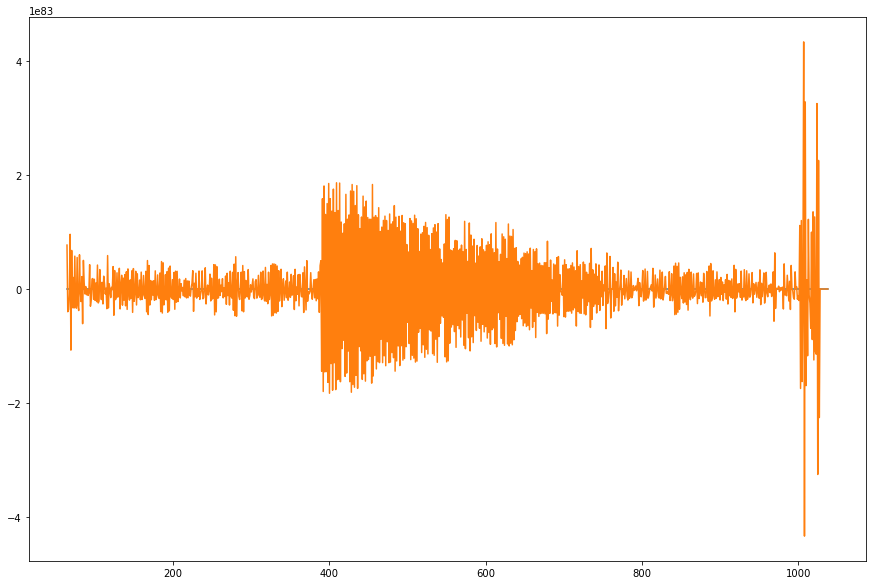

In [77]:
fig = big_figure()
plt.plot(d.fr/d.odo_fr_us*1E6)
print(d[100:105])
for i in range(64):
    d = d + d[i:]
#d = d + d[1:] + d[2:] + d[3:] + d[4:] 
print(d[100:105])
fig = big_figure()
plt.plot(d.fr/d.odo_fr_us*1E6)
fig = big_figure()
plt.plot(d.diff())

In [20]:
fig = plt.figure()

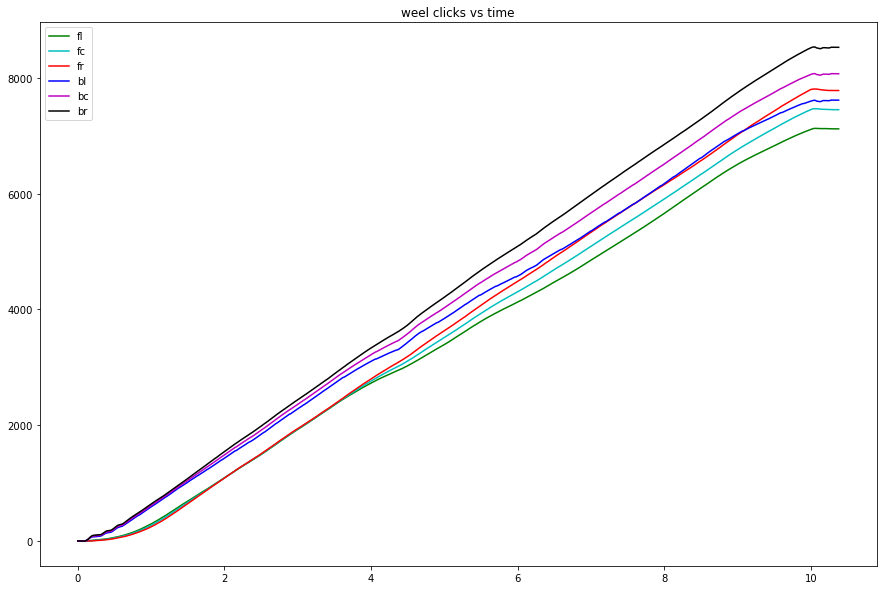

In [24]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)

ratio = 1.25
plt.title('weel clicks vs time')
plt.plot(run.t,run.fl*ratio,color='g',label='fl')
plt.plot(run.t,run.fc*ratio,color='c', label='fc')
plt.plot(run.t,run.fr*ratio,color='r', label='fr')

plt.plot(run.t,run.bl,color='b', label='bl')
plt.plot(run.t,run.bc,color='m', label='bc')
plt.plot(run.t,run.br,color='k', label='br')
plt.legend();